In [1]:
!pip install torch torchvision matplotlib numpy scikit-learn


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from PIL import Image


In [16]:
# Define dataset paths
train_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/train/"
test_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/test/"
valid_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/valid/"

# Hyperparameters
img_height, img_width = 224, 224
batch_size = 16
num_classes = 2
learning_rate = 0.001
num_epochs = 40#30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transforms)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = train_dataset.classes
print("Class Names:", class_names)


Class Names: ['normal', 'varicose']


In [12]:
# Load pretrained ResNeXt50 model
model = models.resnext50_32x4d(pretrained=True)

# Modify the classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, num_classes),
    nn.Softmax(dim=1)
)

# Move model to GPU if available
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)


C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [13]:
train_loss_values = []
valid_loss_values = []
train_acc_values = []
valid_acc_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    model.eval()
    valid_loss, correct_valid = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_acc = correct_valid / len(valid_dataset)
    valid_loss_values.append(valid_loss)
    valid_acc_values.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "1-varicose_resnext50.pth")
print("Model saved successfully!")


Epoch 1/30 - Train Loss: 0.4859, Train Acc: 0.7952 - Valid Loss: 0.5859, Valid Acc: 0.7391
Epoch 2/30 - Train Loss: 0.5333, Train Acc: 0.8238 - Valid Loss: 0.5420, Valid Acc: 0.7609
Epoch 3/30 - Train Loss: 0.6659, Train Acc: 0.6714 - Valid Loss: 0.6649, Valid Acc: 0.6522
Epoch 4/30 - Train Loss: 0.6327, Train Acc: 0.6429 - Valid Loss: 0.6373, Valid Acc: 0.6304
Epoch 5/30 - Train Loss: 0.5154, Train Acc: 0.8095 - Valid Loss: 0.6786, Valid Acc: 0.6304
Epoch 6/30 - Train Loss: 0.4604, Train Acc: 0.8714 - Valid Loss: 0.4936, Valid Acc: 0.8261
Epoch 7/30 - Train Loss: 0.4557, Train Acc: 0.8476 - Valid Loss: 0.6276, Valid Acc: 0.6522
Epoch 8/30 - Train Loss: 0.4456, Train Acc: 0.8857 - Valid Loss: 0.6736, Valid Acc: 0.6304
Epoch 9/30 - Train Loss: 0.3985, Train Acc: 0.9095 - Valid Loss: 0.7573, Valid Acc: 0.5652
Epoch 10/30 - Train Loss: 0.6187, Train Acc: 0.7048 - Valid Loss: 0.7898, Valid Acc: 0.5000
Epoch 11/30 - Train Loss: 0.5729, Train Acc: 0.7190 - Valid Loss: 0.6666, Valid Acc: 0.63

In [14]:
model.eval()
correct, total = 0, 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Generate classification report
print(classification_report(all_labels, all_preds, target_names=class_names))


Test Accuracy: 84.09%
              precision    recall  f1-score   support

      normal       0.78      0.95      0.86        22
    varicose       0.94      0.73      0.82        22

    accuracy                           0.84        44
   macro avg       0.86      0.84      0.84        44
weighted avg       0.86      0.84      0.84        44



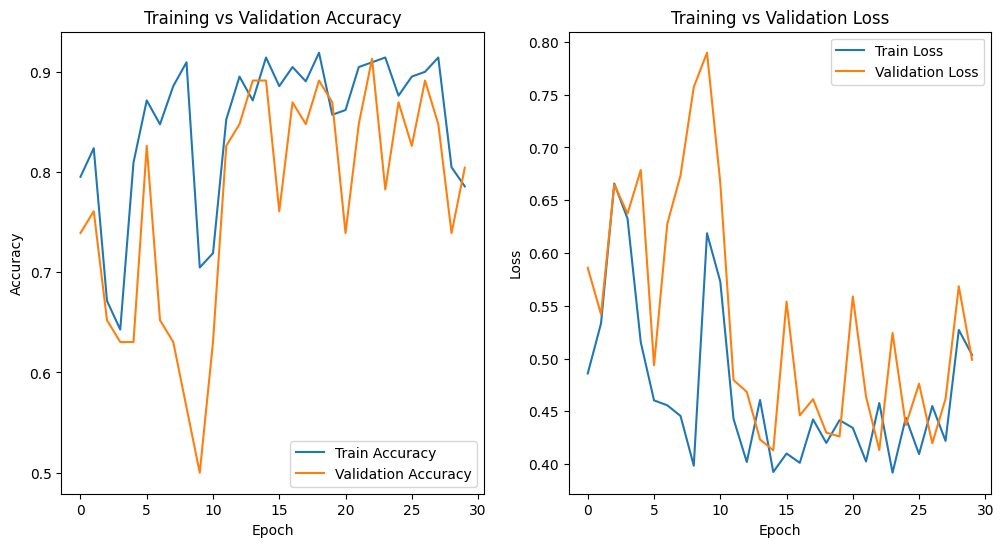

In [15]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(valid_acc_values, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(valid_loss_values, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


In [ ]:
train_loss_values = []
valid_loss_values = []
train_acc_values = []
valid_acc_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    model.eval()
    valid_loss, correct_valid = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_acc = correct_valid / len(valid_dataset)
    valid_loss_values.append(valid_loss)
    valid_acc_values.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "2-varicose_resnext50.pth")
print("Model saved successfully!")


Epoch 1/40 - Train Loss: 0.4718, Train Acc: 0.8571 - Valid Loss: 0.7980, Valid Acc: 0.5000
Epoch 2/40 - Train Loss: 0.4814, Train Acc: 0.8524 - Valid Loss: 0.5782, Valid Acc: 0.7391
Epoch 3/40 - Train Loss: 0.4846, Train Acc: 0.8381 - Valid Loss: 0.5059, Valid Acc: 0.8043
Epoch 4/40 - Train Loss: 0.5744, Train Acc: 0.7524 - Valid Loss: 0.6093, Valid Acc: 0.6957
Epoch 5/40 - Train Loss: 0.4657, Train Acc: 0.8333 - Valid Loss: 0.5920, Valid Acc: 0.7174
Epoch 6/40 - Train Loss: 0.5733, Train Acc: 0.7143 - Valid Loss: 0.6310, Valid Acc: 0.6739
Epoch 7/40 - Train Loss: 0.5611, Train Acc: 0.7905 - Valid Loss: 0.5322, Valid Acc: 0.7826
Epoch 8/40 - Train Loss: 0.6160, Train Acc: 0.7333 - Valid Loss: 0.5636, Valid Acc: 0.7174
Epoch 9/40 - Train Loss: 0.4640, Train Acc: 0.8429 - Valid Loss: 0.4778, Valid Acc: 0.8261
Epoch 10/40 - Train Loss: 0.4458, Train Acc: 0.8952 - Valid Loss: 0.4477, Valid Acc: 0.8696
Epoch 11/40 - Train Loss: 0.4929, Train Acc: 0.8762 - Valid Loss: 0.5126, Valid Acc: 0.80

In [20]:
import torch

# Initialize variables to track the best model
best_valid_acc = 0.0  # Store the best validation accuracy
best_epoch = 0  # Track the epoch with the best accuracy

train_loss_values = []
valid_loss_values = []
train_acc_values = []
valid_acc_values = []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)
    train_loss_values.append(train_loss)
    train_acc_values.append(train_acc)

    model.eval()
    valid_loss, correct_valid = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_acc = correct_valid / len(valid_dataset)
    valid_loss_values.append(valid_loss)
    valid_acc_values.append(valid_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    # **Save the best model based on validation accuracy**
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), "best_varicose_resnext50.pth")
        print(f"🔥 New best model saved at epoch {best_epoch} with accuracy: {best_valid_acc:.4f}")

print(f"Training complete! Best model was at epoch {best_epoch} with accuracy {best_valid_acc:.4f}")


Epoch 1/40 - Train Loss: 0.4519, Train Acc: 0.8524 - Valid Loss: 0.4495, Valid Acc: 0.8478
🔥 New best model saved at epoch 1 with accuracy: 0.8478
Epoch 2/40 - Train Loss: 0.3998, Train Acc: 0.9095 - Valid Loss: 0.4540, Valid Acc: 0.8478
Epoch 3/40 - Train Loss: 0.4099, Train Acc: 0.9286 - Valid Loss: 0.4294, Valid Acc: 0.8913
🔥 New best model saved at epoch 3 with accuracy: 0.8913
Epoch 4/40 - Train Loss: 0.4358, Train Acc: 0.9000 - Valid Loss: 0.3975, Valid Acc: 0.9130
🔥 New best model saved at epoch 4 with accuracy: 0.9130
Epoch 5/40 - Train Loss: 0.4081, Train Acc: 0.9333 - Valid Loss: 0.4326, Valid Acc: 0.8696
Epoch 6/40 - Train Loss: 0.4660, Train Acc: 0.8714 - Valid Loss: 0.4412, Valid Acc: 0.8696
Epoch 7/40 - Train Loss: 0.4069, Train Acc: 0.9000 - Valid Loss: 0.4884, Valid Acc: 0.8261
Epoch 8/40 - Train Loss: 0.4506, Train Acc: 0.8905 - Valid Loss: 0.4240, Valid Acc: 0.8913
Epoch 9/40 - Train Loss: 0.3956, Train Acc: 0.9143 - Valid Loss: 0.3969, Valid Acc: 0.9130
Epoch 10/40 -

In [30]:
import torch
from sklearn.metrics import classification_report

# Load the best model
best_model_path = "best_varicose_resnext50.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)  # Ensure model is on the correct device
model.eval()

correct, total = 0, 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute Test Accuracy
accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.2f}%")

# Generate Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


✅ Test Accuracy: 88.64%
Classification Report:
              precision    recall  f1-score   support

      normal       0.90      0.86      0.88        22
    varicose       0.87      0.91      0.89        22

    accuracy                           0.89        44
   macro avg       0.89      0.89      0.89        44
weighted avg       0.89      0.89      0.89        44



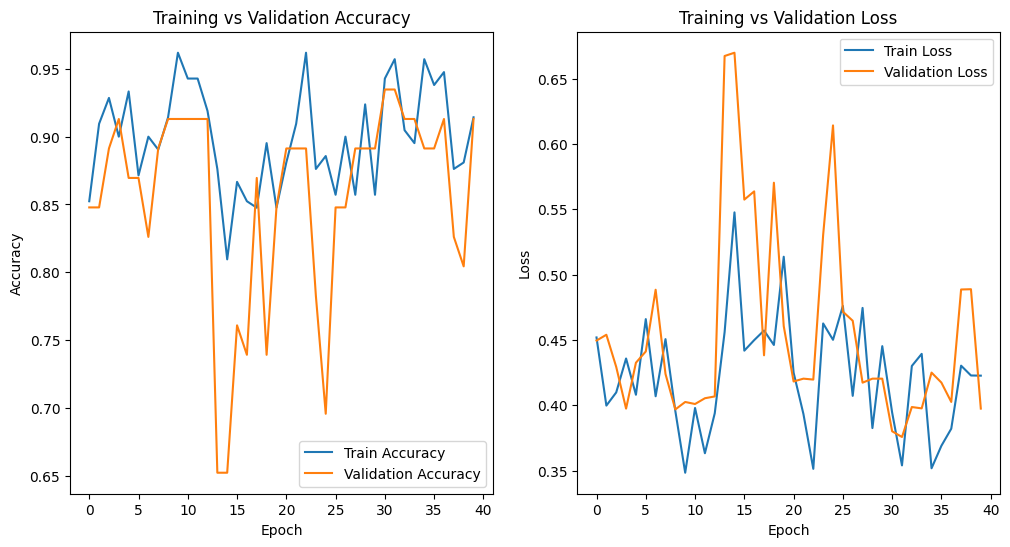

In [24]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_values, label='Train Accuracy')
plt.plot(valid_acc_values, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_values, label='Train Loss')
plt.plot(valid_loss_values, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


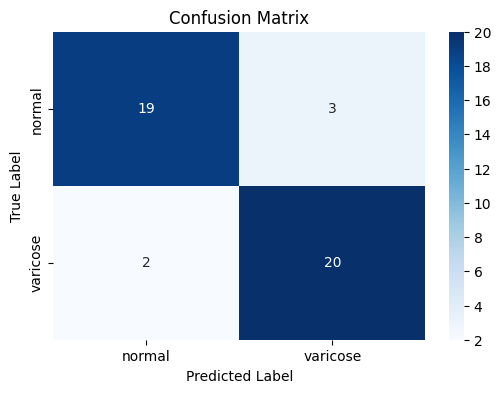

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


The image is classified as: varicose


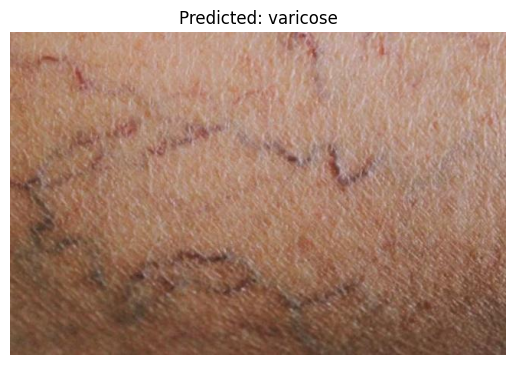

In [23]:
# Load a test image for prediction
test_image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/Dataset_new (1)/VARICOSE_VEINS_own/test/varicose/58_jpeg.rf.8522e59123b36d6d23b859456e609e22.jpg"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


The image is classified as: normal


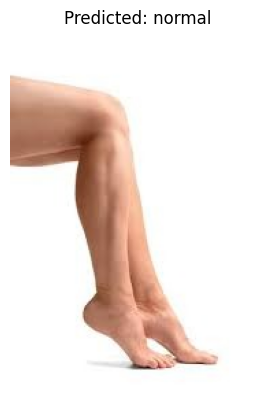

In [25]:
# Load a test image for prediction
test_image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/Dataset_new (1)/VARICOSE_VEINS_own/valid/normal/nor_image_197_jpeg.978jsanija.jpeg"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


The image is classified as: varicose


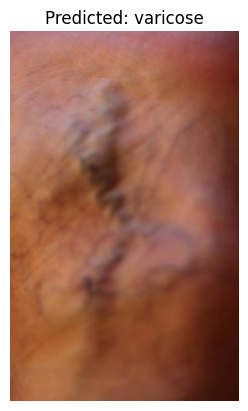

In [27]:
# Load a test image for prediction
test_image_path = "test3.png"

# Load and preprocess image
img = Image.open(test_image_path)
img = test_transforms(img)
img = img.unsqueeze(0).to(device)  # Add batch dimension

# Make predictions
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

print(f"The image is classified as: {predicted_class}")

# Display the image
plt.imshow(Image.open(test_image_path))
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [13]:
torch.save(model.state_dict(), "varicose_resnext50.pth")



🔍 Classification Result: Varicose Veins


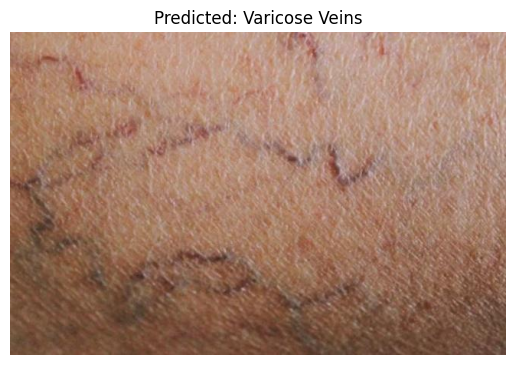

In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt

# Load trained classification model
classification_model = models.resnext50_32x4d(pretrained=False)
classification_model.fc = nn.Sequential(
    nn.Linear(classification_model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

# Load saved weights
classification_model.load_state_dict(torch.load("varicose_resnext50.pth", map_location=torch.device("cpu")))
classification_model.eval()  # Set to evaluation mode

# Define transformation (same as used in training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load an image for testing
test_image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/58_jpeg.rf.8522e59123b36d6d23b859456e609e22.jpg"
img = Image.open(test_image_path)
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

# Perform classification
with torch.no_grad():
    output = classification_model(img_tensor)
    _, predicted = torch.max(output, 1)

class_names = ["Normal", "Varicose Veins"]
predicted_class = class_names[predicted.item()]

print(f"\n🔍 Classification Result: {predicted_class}")

# Display image with result
plt.imshow(img)
plt.title(f"Predicted: {predicted_class}")
plt.axis("off")
plt.show()


In [5]:
# Check if image is classified as Varicose Veins
if predicted_class == "Varicose Veins":
    print("\n✅ Varicose Veins Detected! Now determining the stage...")
else:
    print("\n❌ Normal Image Detected. No staging required.")



✅ Varicose Veins Detected! Now determining the stage...


In [39]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

# Define dataset paths (Same dataset used)
train_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/train/"
valid_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/valid/"
test_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/test/"

# Update the number of classes (Assuming 4 stages)
num_stages = 4  

# Load the dataset (Same as classification, but now for staging)
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Load Pretrained ResNeXt Model
staging_model = models.resnext50_32x4d(pretrained=True)

# Modify final classifier for staging classification
staging_model.fc = nn.Sequential(
    nn.Linear(staging_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_stages),
    nn.Softmax(dim=1)
)

# Move model to CPU
device = torch.device("cpu")
staging_model = staging_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(staging_model.parameters(), lr=0.0005)

# Training the Staging Model
num_epochs = 30
print("\n🚀 Starting Training for Staging Model...\n")

for epoch in range(num_epochs):
    staging_model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = staging_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

# Save trained staging model
torch.save(staging_model.state_dict(), "1t-varicose_staging_resnext50.pth")
print("\n✅ Staging Model Saved Successfully!")


C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vinod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



🚀 Starting Training for Staging Model...

Epoch 1/30 - Train Loss: 1.0337, Train Acc: 0.7190
Epoch 2/30 - Train Loss: 0.9620, Train Acc: 0.8048
Epoch 3/30 - Train Loss: 0.9810, Train Acc: 0.7476
Epoch 4/30 - Train Loss: 0.9334, Train Acc: 0.8048
Epoch 5/30 - Train Loss: 0.9952, Train Acc: 0.7714
Epoch 6/30 - Train Loss: 0.9579, Train Acc: 0.7857
Epoch 7/30 - Train Loss: 0.8990, Train Acc: 0.8667
Epoch 8/30 - Train Loss: 1.2741, Train Acc: 0.4571
Epoch 9/30 - Train Loss: 1.2606, Train Acc: 0.4810
Epoch 10/30 - Train Loss: 1.0972, Train Acc: 0.6524
Epoch 11/30 - Train Loss: 0.9897, Train Acc: 0.7476
Epoch 12/30 - Train Loss: 0.9433, Train Acc: 0.7905
Epoch 13/30 - Train Loss: 1.0442, Train Acc: 0.6857
Epoch 14/30 - Train Loss: 1.1123, Train Acc: 0.6381
Epoch 15/30 - Train Loss: 1.0478, Train Acc: 0.6857
Epoch 16/30 - Train Loss: 0.9756, Train Acc: 0.7571
Epoch 17/30 - Train Loss: 1.0260, Train Acc: 0.7238
Epoch 18/30 - Train Loss: 1.0091, Train Acc: 0.7238
Epoch 19/30 - Train Loss: 0.99

In [35]:

from torchvision import transforms

# Define transformations for dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),           
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

# Load datasets with transformations
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=transform)


In [37]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn

# Define dataset paths
train_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/train/"
valid_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/valid/"
test_data_dir = "Dataset_new (1)/VARICOSE_VEINS_own/test/"

# Number of classes (stages)
num_stages = 4  

# Load datasets
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

# Load Pretrained ResNeXt Model
staging_model = models.resnext50_32x4d(pretrained=True)

# Modify final classifier for staging classification
staging_model.fc = nn.Sequential(
    nn.Linear(staging_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_stages),
    nn.Softmax(dim=1)
)

# Move model to CPU
device = torch.device("cpu")
staging_model = staging_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(staging_model.parameters(), lr=0.0005)

# Training the Staging Model with Best Model Saving
num_epochs = 30
best_val_acc = 0.0  # Track best validation accuracy
best_model_path = "best_varicose_resnext50.pth"

print("\n🚀 Starting Training for Staging Model...\n")

for epoch in range(num_epochs):
    staging_model.train()
    train_loss, correct_train = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = staging_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct_train / len(train_dataset)

    # ---- Validation Phase ----
    staging_model.eval()
    valid_loss, correct_valid = 0, 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = staging_model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()

    valid_loss /= len(valid_loader)
    valid_acc = correct_valid / len(valid_dataset)

    # Save model if validation accuracy improves
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        torch.save(staging_model.state_dict(), best_model_path)
        print(f"\n Model Saved! Best Validation Accuracy: {best_val_acc:.4f} at Epoch {epoch+1}")

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

print("\n Training Complete! Best Model Saved as:", best_model_path)



🚀 Starting Training for Staging Model...


 Model Saved! Best Validation Accuracy: 0.8478 at Epoch 1
Epoch 1/30 - Train Loss: 0.9908, Train Acc: 0.7524 - Valid Loss: 0.9198, Valid Acc: 0.8478
Epoch 2/30 - Train Loss: 0.9367, Train Acc: 0.8143 - Valid Loss: 1.1483, Valid Acc: 0.5652

 Model Saved! Best Validation Accuracy: 0.8696 at Epoch 3
Epoch 3/30 - Train Loss: 0.9205, Train Acc: 0.8095 - Valid Loss: 0.8959, Valid Acc: 0.8696
Epoch 4/30 - Train Loss: 0.8972, Train Acc: 0.8619 - Valid Loss: 0.9550, Valid Acc: 0.7826
Epoch 5/30 - Train Loss: 0.8812, Train Acc: 0.8762 - Valid Loss: 0.9161, Valid Acc: 0.8261
Epoch 6/30 - Train Loss: 0.9078, Train Acc: 0.8429 - Valid Loss: 0.9992, Valid Acc: 0.7174
Epoch 7/30 - Train Loss: 0.9017, Train Acc: 0.8667 - Valid Loss: 0.9656, Valid Acc: 0.7826
Epoch 8/30 - Train Loss: 0.8624, Train Acc: 0.8762 - Valid Loss: 1.1587, Valid Acc: 0.5652

 Model Saved! Best Validation Accuracy: 0.8913 at Epoch 9
Epoch 9/30 - Train Loss: 0.9727, Train Acc: 0.7571 -

In [38]:
from sklearn.metrics import classification_report
import numpy as np

# Load the best model
staging_model.load_state_dict(torch.load(best_model_path, map_location=device))
staging_model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
pred_labels = []

# Evaluate on test set
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = staging_model(images)
        _, predicted = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

# Generate classification report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=test_dataset.classes))



Classification Report:

              precision    recall  f1-score   support

      normal       0.85      0.77      0.81        22
    varicose       0.79      0.86      0.83        22

    accuracy                           0.82        44
   macro avg       0.82      0.82      0.82        44
weighted avg       0.82      0.82      0.82        44




🩺 The detected stage of Varicose Veins is: Stage 2


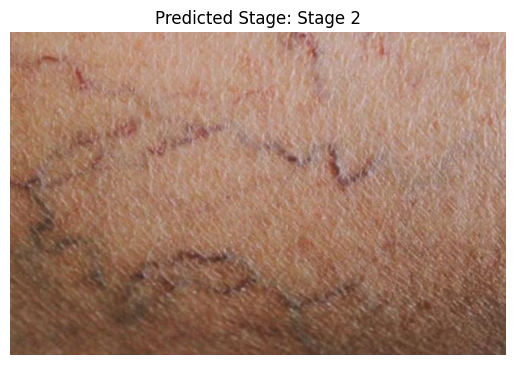

In [ ]:
# Load trained staging model
staging_model.load_state_dict(torch.load("varicose_staging_resnext50.pth", map_location=device))
staging_model.eval()

# Load and preprocess the image (same image used for classification)
img_tensor = transform(img).unsqueeze(0).to(device)

# Predict stage
with torch.no_grad():
    output = staging_model(img_tensor)
    _, predicted_stage = torch.max(output, 1)


stage_names = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"]
predicted_stage_label = stage_names[predicted_stage.item()]

print(f"\n🩺 The detected stage of Varicose Veins is: {predicted_stage_label}")

# Display image with result
plt.imshow(img)
plt.title(f"Predicted Stage: {predicted_stage_label}")
plt.axis("off")
plt.show()


Varicose veins are clinically staged based on severity and visual characteristics. The widely used CEAP (Clinical-Etiology-Anatomy-Pathophysiology) classification defines different stages:

🚦 CEAP Classification for Varicose Veins
Stage	Description	Visual Indicators
Stage 1 (Mild)	Spider veins (telangiectasia)	Small, web-like veins, no swelling
Stage 2 (Moderate)	Varicose veins visible	Twisted, enlarged veins, mild discomfort
Stage 3 (Severe)	Swelling (Edema)	Veins bulging, leg swelling without skin changes
Stage 4 (Critical)	Skin changes, ulcers	Skin darkening, open sores, blood pooling
![alt text](image-1.png)